In [33]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import markers
import os
import json
from pathlib2 import Path
import copy
from functools import reduce

In [4]:
def plt_sz(d):
    '''Plot size. User enters dimensions in tuple. Returns fix, ax for plot.'''
    fig, ax = plt.subplots(figsize = d)
    return fig, ax

def pad_lab(a, amt):
    a.yaxis.labelpad = amt

def cht_format(cht, titl, t_fnt, xlab, xlab_fnt, ylab, ylab_fnt, tck_params, rot_xlab = None):
    cht.axes.set_title(titl, fontsize = t_fnt)
    cht.set_xlabel(xlab, fontsize = xlab_fnt)
    cht.set_ylabel(ylab, fontsize = ylab_fnt)
    cht.tick_params(labelsize = tck_params)
    if rot_xlab:
        #Setting to variable so labels are not printed.
        labs = cht.set_xticklabels(cht.get_xticklabels(), rotation = rot_xlab)

def leg_fnt(a, f):
    '''Sets legend title and font size. Relies on inputting axis from plot.'''
    plt.setp(a.get_legend().get_texts(), fontsize = f) # for legend text
    plt.setp(a.get_legend().get_title(), fontsize = f) # for legend title
        
def ind_order(df, col, top = None):
    '''Returns indices of select df and col in order. If top integer used, selects top values only.'''
    return df.loc[:, col].value_counts().index[:top] if top else df.loc[:, col].value_counts()

def lineplt(d, x, y, **params):
    l = sns.lineplot(data = d, x = x, y = y, hue = params['hue'], ci = params['ci'], ax = params['ax'],
                     color = params['clr'], palette = params['pal'], label = params['lab'],
                     legend = params['leg'])
    return l

def chg_arg(d, **kwargs):
    '''Returns amended dict from original dict and does not change the original using deepcopy.
    Supports amending plotting parameters'''
    #deepcopy dict to not change original.
    d2 = copy.deepcopy(d)
    for k, v in kwargs.items():
        d2[k] = v
    return d2

def cnt_plt(dat, x, clr, order = None):
    chart = None
    if not order:
        chart = sns.countplot(data = dat, x = x, color = clr)
    else:
        if isinstance(order, bool):
            chart = sns.countplot(data = dat, x = x, color = clr, order = dat.loc[:, x].value_counts().index)
        else:
            chart = sns.countplot(data = dat, x = x, color = clr, order = dat.loc[:, x].value_counts().index[:order])
    return chart

def pairs_binary(df, h, p, alp, vs):
    '''Plots a pairplot.'''
    test_plot = sns.pairplot(df, hue = h, palette = p, plot_kws = {'alpha': alp}, vars = vs)
    #To suppress upper portion of plot.
    #https://stackoverflow.com/questions/34087126/plot-lower-triangle-in-a-seaborn-pairgrid
    for i, j in zip(*np.triu_indices_from(test_plot.axes, 1)):
        test_plot.axes[i, j].set_visible(False)
    return test_plot

def default_mpl():
    '''Resets default matplotlib rcparams in case changed params along the way or need to reset.'''
    mpl.rcParams.update(mpl.rcParamsDefault)

def leg(mfc, lab):
    '''Creates custom legend elements for this specific project.'''
    return Line2D([0], [0], marker = 'o', color = 'w', label = lab, markerfacecolor = mfc, markersize = 10)

def cor_hmap(df, color):
    '''Heatmap table for correlation matrix. User supplies df with only columns wanted.'''
    cm = df.corr()
    mask = np.triu(np.ones_like(cm, dtype=bool))
    sns.heatmap(cm, cmap = color, mask = mask)

def mean_median(df, cols, med = False):
    '''Returns 2 column df with mean or median depending on med argument. One col is a category and the other
    is the number to be aggregated.'''
    res = df[cols].groupby(cols[0]).mean().sort_values(cols[1]).reset_index()
    res.loc[:, cols[1]] = res.loc[:, cols[1]].round(2)
    return df[cols].groupby(cols[0]).median().sort_values(cols[1]).reset_index() if med else res

In [3]:
#Reading in originally prepared data.
df = pd.read_excel('10_11_20_prepped.xlsx')

# Plots for originally prepared data.

#Number of Records vs. Mean Total Compensation Over Time

In [4]:
dim1 = (8, 8)
#Setting line parameters.
params = {'hue': None, 'ci': None, 'ax': None, 'pal': None, 'clr': 'dodgerblue', 'lab': 'Records', 'leg': False}
#Setting plot background.
sns.set_style('whitegrid')

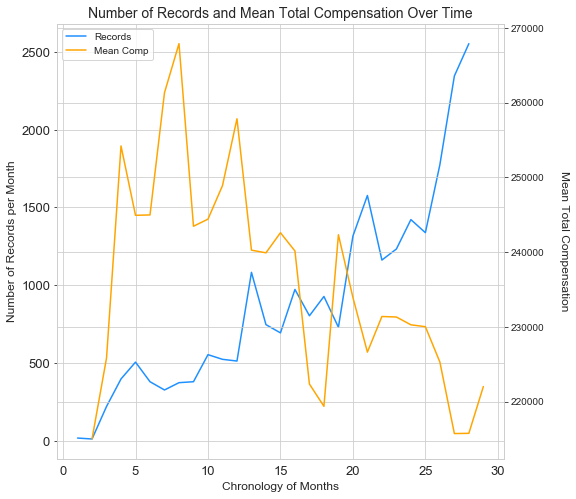

In [5]:
cnt = df.Chronology.value_counts()
#Removing last record since only half a month's data collected for number of records line.
cnt = cnt.sort_index()[:-1]
fig, ax = plt_sz(dim1)
l = lineplt(cnt, cnt.index, cnt.values, **params)
#Second axis.
ax2 = ax.twinx()
#Amending original chart params for second line.
p2 = chg_arg(params, **{'ax': ax2, 'clr': 'orange', 'lab': 'Mean Comp'})
#First month has high mean.
# l2 = lineplt(df, 'Chronology', 'Total Compensation', **p2)
# #First month has grossly high mean, which results in odd plot. Omitting the first month results in this.
l2 = lineplt(df[df.Chronology > 1], 'Chronology', 'Total Compensation', **p2)
#For legend.
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax.legend(lines, labels, loc = 0)
#Setting y label for second axis.
ax2.set_ylabel('Mean Total Compensation', rotation = 270, fontsize = 12)
# ax2.yaxis.labelpad = 25
pad_lab(ax2, 25)

cht_format(l, 'Number of Records and Mean Total Compensation Over Time',
           14, 'Chronology of Months', 12, 'Number of Records per Month', 12, 13, rot_xlab = None)

#Domestic vs. International

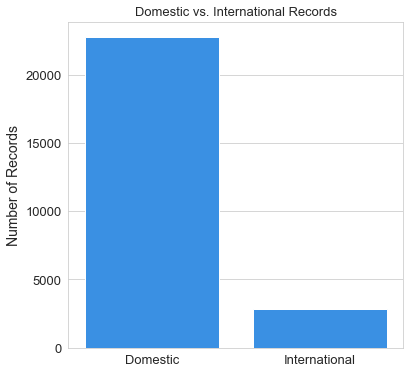

In [6]:
dim2 = (6, 6)
fig, ax = plt_sz(dim2)
di = cnt_plt(df, 'Domestic_International', params['clr'])
cht_format(di, 'Domestic vs. International Records', 13, '', 14, 'Number of Records', 14, 13)

#Number of Records per Year

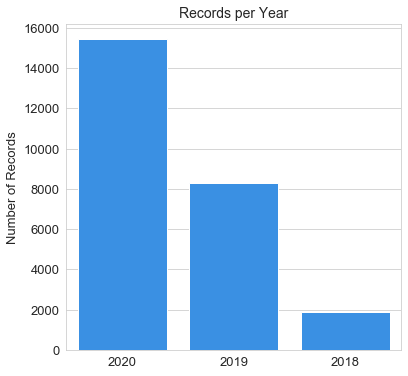

In [7]:
#Somewhat similar to the line chart above, but above showed number of records per month
fig, ax = plt_sz(dim2)
yrs = cnt_plt(df, 'Year', params['clr'], order = True)
cht_format(yrs, 'Records per Year', 14, '', 14, 'Number of Records', 13, 13)

#Number of Jobs

In [332]:
#Temp df to reflect top jobs, abbreviating long job names.
df_temp = df
job_map = {'Software Engineer': 'Software Engineer', 'Product Manager': 'Product Manager',
           'Software Engineering Manager': 'SW Eng. Mgr.', 'Data Scientist': 'Data Scientist',
           'Hardware Engineer': 'Hardware Engineer', 'Product Designer': 'Product Designer',
           'Solution Architect': 'Solution Architect', 'Technical Program Manager': 'Tech. Prog. Mgr.',
           'Management Consultant': 'Mgmt. Consultant', 'Marketing': 'Marketing'}
df_temp.Job = df_temp.Job.map(job_map)

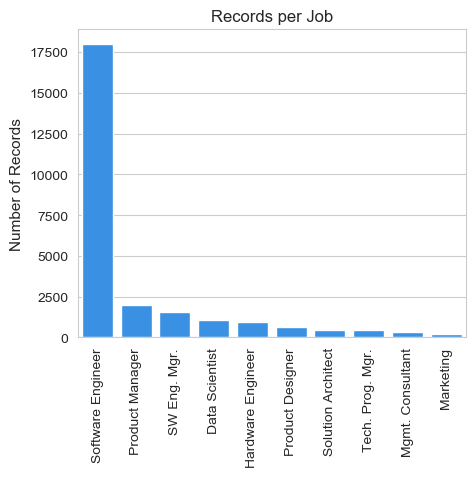

In [336]:
fig, ax = plt_sz((5, 4))
jobs = cnt_plt(df_temp, 'Job', params['clr'], order = True)
cht_format(jobs, 'Records per Job', 12, '', 11, 'Number of Records', 11, 10, rot_xlab = 90)

#Number of jobs by location.

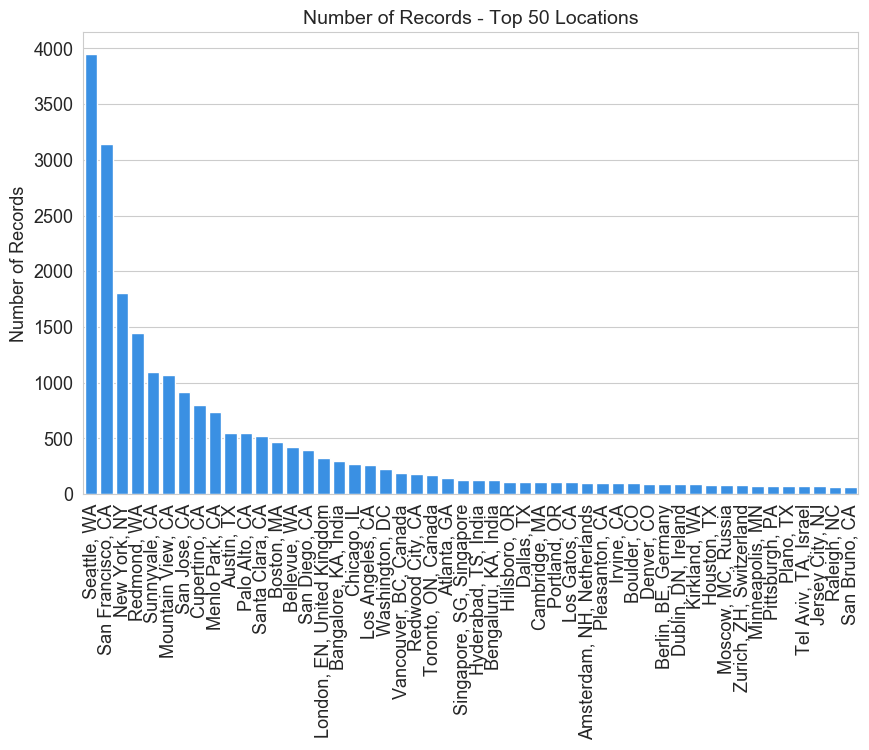

In [284]:
dim3 = (10, 10)
dim4 = (10, 6)
fig, ax = plt_sz(dim4)
loc = cnt_plt(df, 'Location', params['clr'], order = 50)
cht_format(loc, 'Number of Records - Top 50 Locations', 14, '', 14, 'Number of Records', 13, 13, rot_xlab = 90)

#Number of Records per US Location.

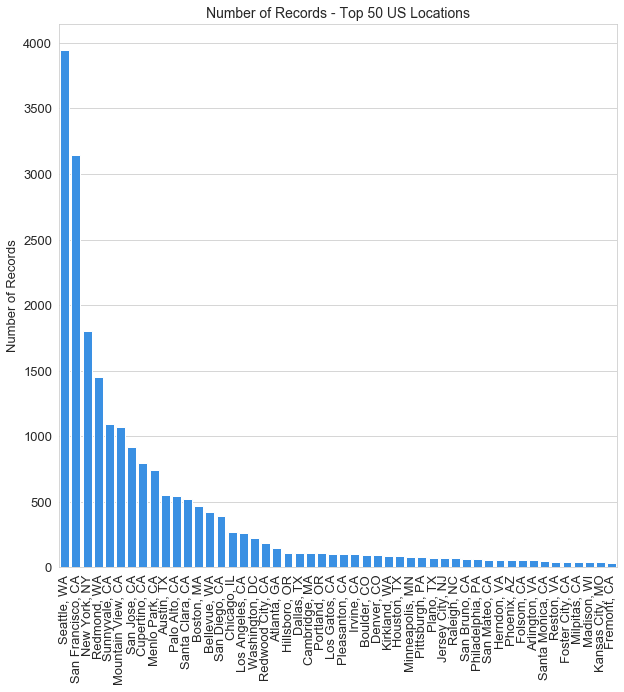

In [10]:
fig, ax = plt_sz(dim3)
loc_us = cnt_plt(df[df.Domestic_International == 'Domestic'], 'Location', params['clr'], order = 50)
cht_format(loc_us, 'Number of Records - Top 50 US Locations', 14, '', 14, 'Number of Records', 13, 13, rot_xlab = 90)

#Top Company Number of Records.

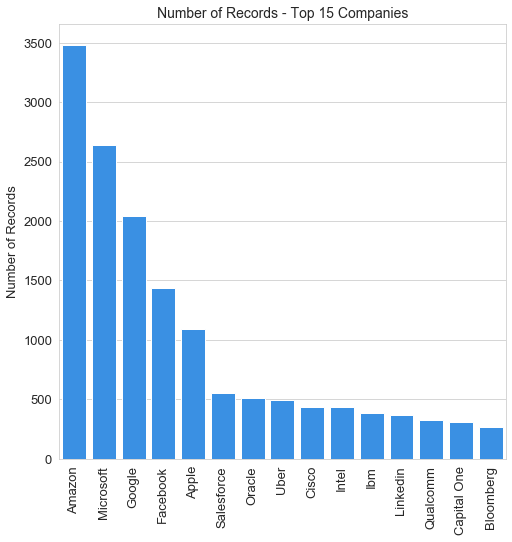

In [11]:
fig, ax = plt_sz(dim1)
cp = cnt_plt(df, 'Company', params['clr'], order = 15)
cht_format(cp, 'Number of Records - Top 15 Companies', 14, '', 13, 'Number of Records', 13, 13, rot_xlab = 90)

#Scatterplot of total experience against total comp, base, stock, and bonus.

C:\Users\Chris_D\Anaconda3\lib\site-packages\seaborn\axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


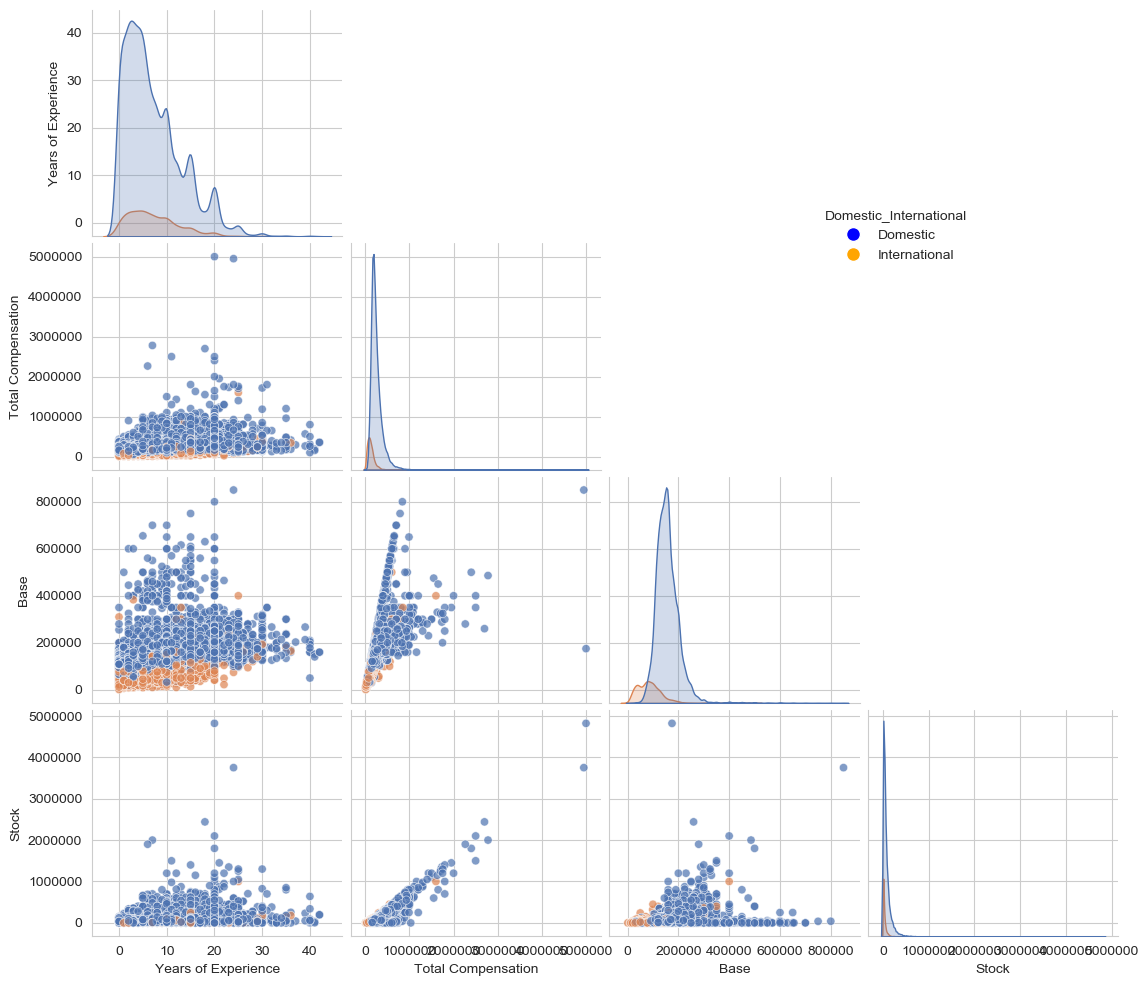

In [293]:
# cols = ['Years of Experience', 'Total Compensation', 'Base', 'Stock', 'Bonus']
#Removing bonus to make visual easier to read.
cols = ['Years of Experience', 'Total Compensation', 'Base', 'Stock']
sp = pairs_binary(df, 'Domestic_International', 'deep', .7, cols)
sp._legend.remove()
legend_elements = [leg('blue', 'Domestic'), leg('orange', 'International')]
sp.add_legend(handles = legend_elements, bbox_to_anchor = [0.75, 0.75], title = 'Domestic_International')
plt.savefig('scatterplot.jpg')

#sp.fig.suptitle('Gender', x = .5, y = .3)
#Getting axis to support plot.
# ax = plt.gca()
# plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

#Interesting corollary between stock and total compensation.

C:\Users\Chris_D\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


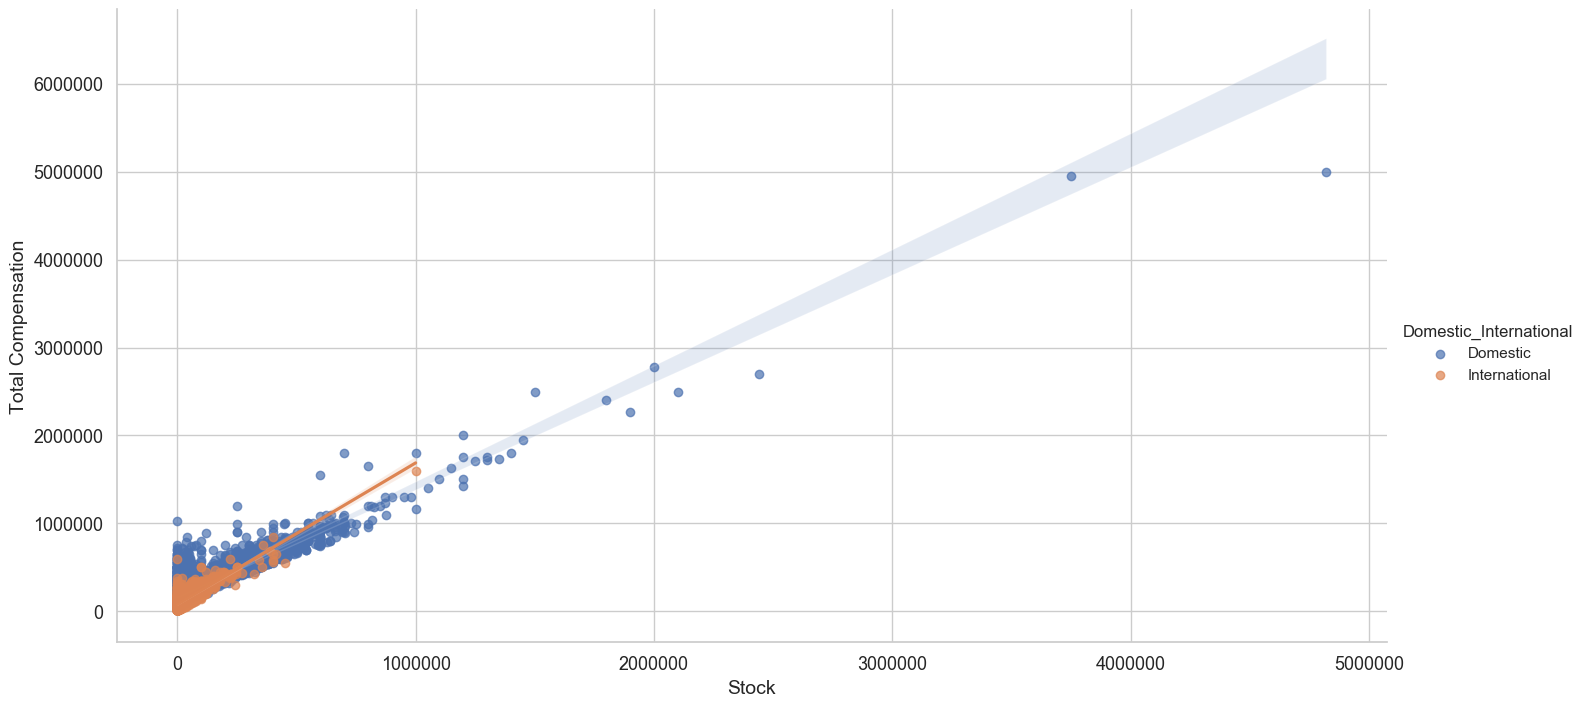

In [42]:
#To manually set styles if sns plot does not take ax.
#http://alanpryorjr.com/visualizations/seaborn/lmplot/lmplot/
#https://matplotlib.org/tutorials/introductory/customizing.html
sns.set_style('whitegrid')
sns.lmplot(x = 'Stock', y = 'Total Compensation', hue = 'Domestic_International',
           data = df, palette = 'deep', scatter_kws={'alpha': .7}, height = 7,
           aspect = 2, legend_out = True)
sns.set(rc = {'xtick.labelsize':13, 'ytick.labelsize':13, 'axes.labelsize': 14})
#Resetting back to default formatting and setting whitegrid style again.
default_mpl()
sns.set_style('whitegrid')

In [56]:
#Wow - .90 correlation - obviously not causal.
np.corrcoef(df.Stock, df.loc[:, 'Total Compensation'])[1][0]

0.9054911450742498

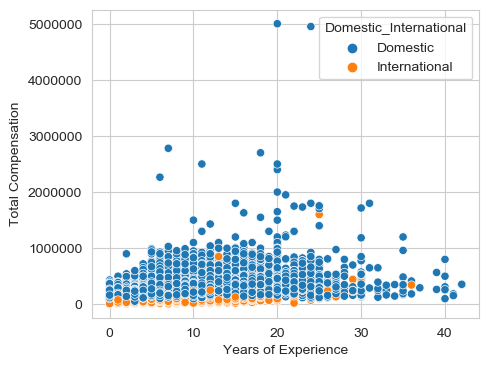

In [292]:
fig, ax = plt_sz((5, 4))
sns.scatterplot(data = df, x = 'Years of Experience', y = 'Total Compensation', hue = 'Domestic_International')

(0, 250000)

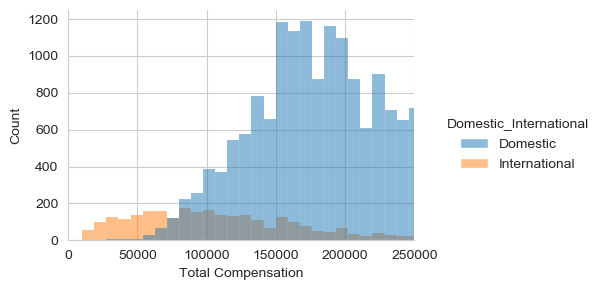

In [295]:
#Have to use height and aspect for size in these plots.
sns.displot(df, x = 'Total Compensation', hue = 'Domestic_International', kind = 'hist',
            fill = True, height = 3, aspect = 1.5)

plt.xlim(0, 250000)

# Further Refined Data - to US Metros.

In [3]:
df_us = pd.read_csv('10_11_20_enriched.csv')

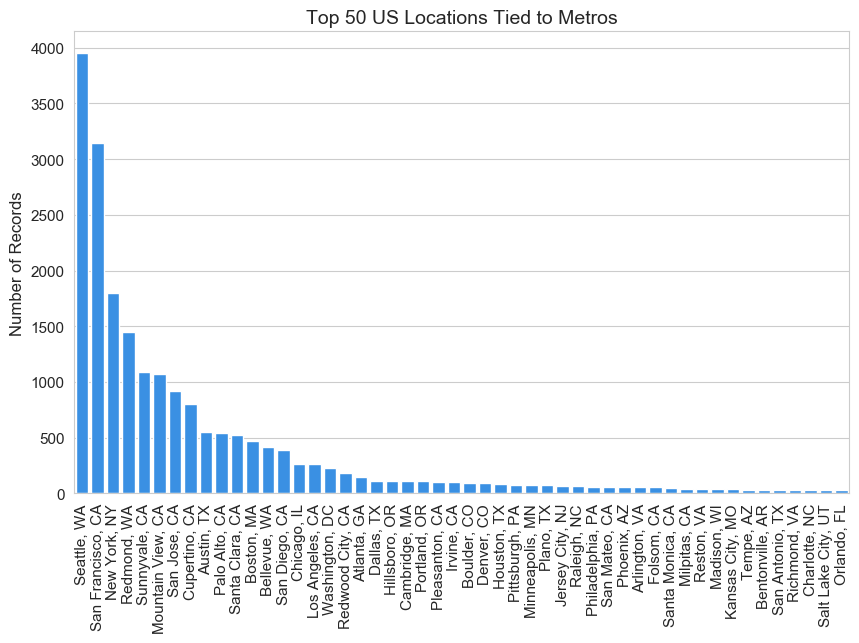

In [74]:
fig, ax = plt_sz(dim4)
us_met = cnt_plt(df_us, 'Location', params['clr'], order = 50)
cht_format(us_met, 'Top 50 US Locations Tied to Metros', 14, '', 14, 'Number of Records', 12, 11, rot_xlab = 90)

In [78]:
#Software Engineers still represent majority. Very few for marketing and management consultant.
df_us.Job.value_counts(normalize = True)

Software Engineer               0.694110
Product Manager                 0.080321
Software Engineering Manager    0.061197
Data Scientist                  0.041308
Hardware Engineer               0.040448
Product Designer                0.025339
Technical Program Manager       0.018024
Solution Architect              0.017307
Management Consultant           0.012670
Marketing                       0.009275
Name: Job, dtype: float64

C:\Users\Chris_D\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Chris_D\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Chris_D\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Chris_D\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Chris_D\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Chris_D\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estima

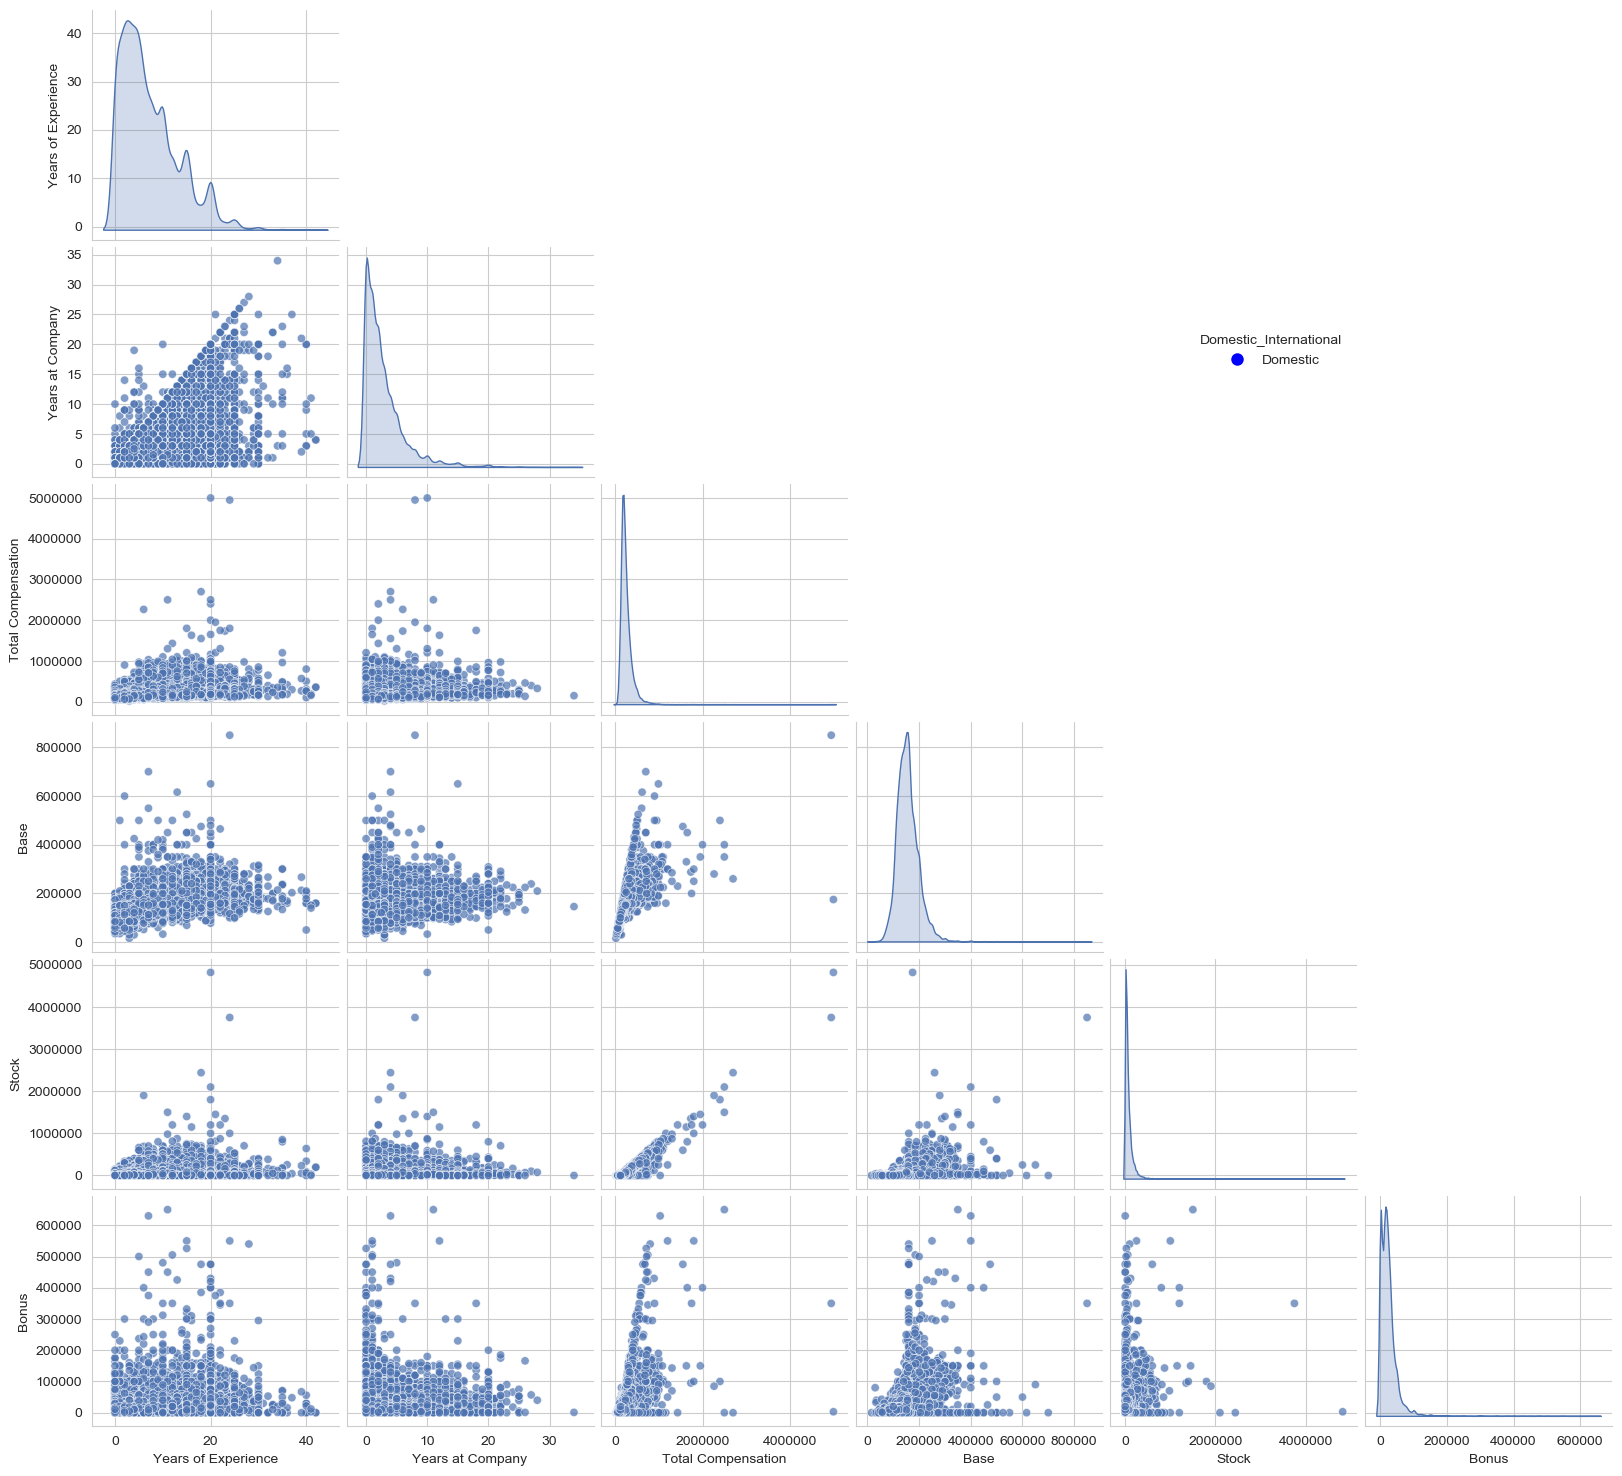

In [273]:
cols = ['Years of Experience', 'Years at Company', 'Total Compensation', 'Base', 'Stock', 'Bonus']
sp = pairs_binary(df_us, 'Domestic_International', 'deep', .7, cols)
sp._legend.remove()
legend_elements = [leg('blue', 'Domestic')]#, leg('orange', 'International')]
sp.add_legend(handles = legend_elements, bbox_to_anchor = [0.75, 0.75], title = 'Domestic_International')

In [81]:
#Heatmap aggregated by means.  Job on y and chronological months on x.
month_yrs = df_us[['Year', 'Month']].groupby(['Year', 'Month']).count().reset_index()
month_yrs = pd.concat([month_yrs, Series(np.arange(0, len(month_yrs)) + 1, name = 'Chronological')], axis = 1)
by_jobs = pd.merge(df_us, month_yrs, on = ['Year', 'Month'])[['Total Compensation', 'Job', 'Chronological']]
job_piv = pd.pivot_table(by_jobs, index = 'Job', columns = 'Chronological', values = 'Total Compensation',
                         aggfunc = np.mean)

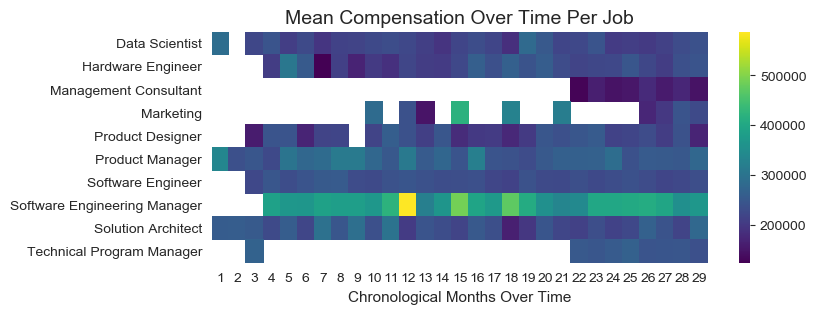

In [346]:
#Probably want to remove management consultant and marketing given ambiguous technical responsibilities and only
#1% of dataset each!
fig, ax = plt_sz((8, 3))
hm1 = sns.heatmap(job_piv, cmap = 'viridis')
cht_format(hm1, 'Mean Compensation Over Time Per Job', 14,
           'Chronological Months Over Time', 11, '', 12, 10, rot_xlab = None)

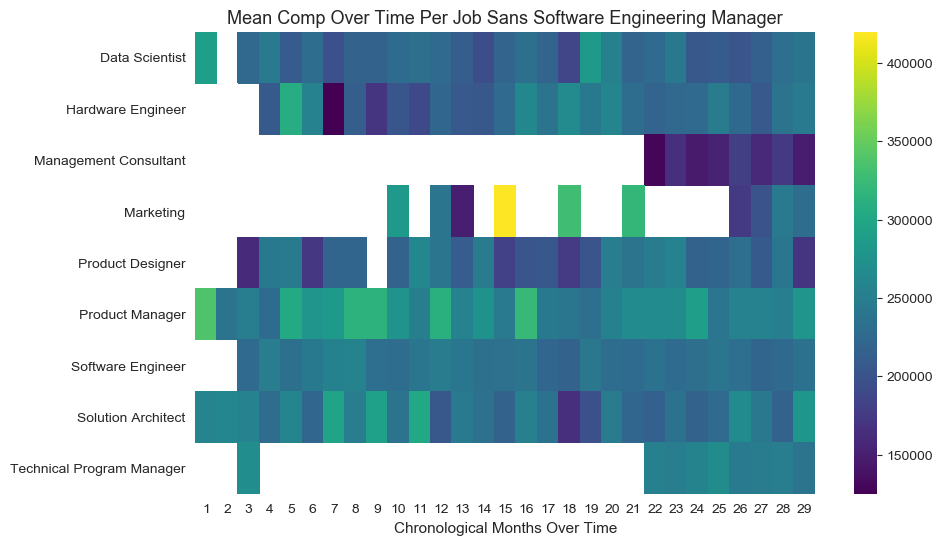

In [110]:
fig, ax = plt_sz(dim4)
hm2 = sns.heatmap(job_piv[job_piv.index != 'Software Engineering Manager'], cmap = 'viridis')
cht_format(hm2, 'Mean Comp Over Time Per Job Sans Software Engineering Manager', 13,
           'Chronological Months Over Time', 11, '', 12, 10, rot_xlab = None)

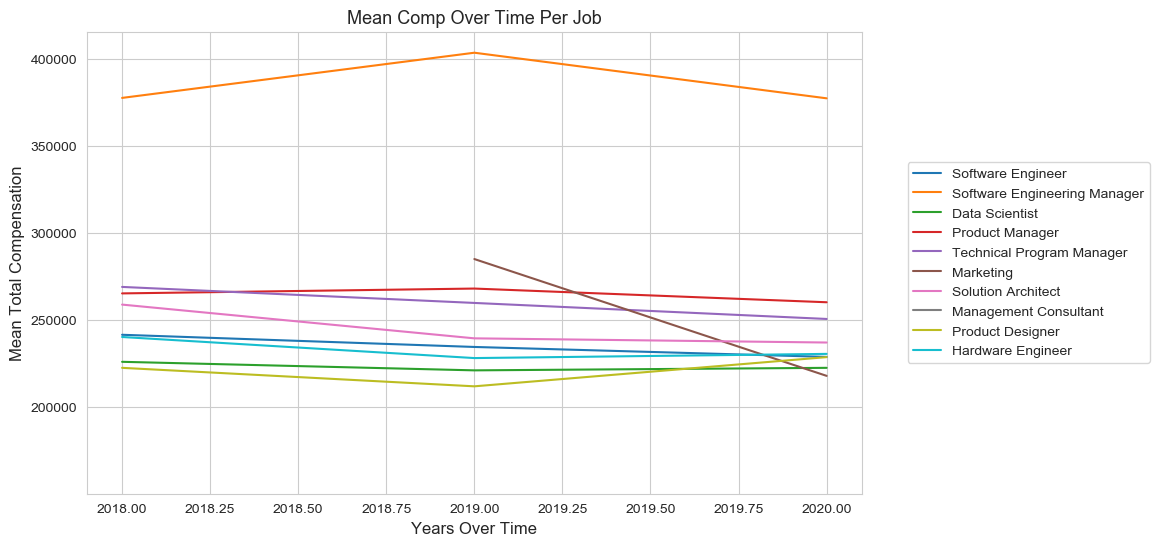

In [285]:
fig, ax = plt_sz(dim4)
#Chronology column on x axis harder to read. Point made with Year on x axis.
#Software Engineering Managers still paid much more - and generally, total comp not going down for jobs over time.
g = sns.lineplot(data = df_us, x = 'Year', y = 'Total Compensation', hue = 'Job',
                 #style = 'Domestic_International',
                 ci = None)
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol = 1)
cht_format(g, 'Mean Comp Over Time Per Job', 13,
           'Years Over Time', 12, 'Mean Total Compensation', 12, 10, rot_xlab = None)

In [124]:
#Creating subset of software engineering manager to benchmark distribution against all data to see if needs
#to be considered on its own.

swem = df_us[['Job', 'Total Compensation']]
swem.loc[:, 'Job Type'] = np.where(df_us.Job == 'Software Engineering Manager', 'SWEM', 'Other')

C:\Users\Chris_D\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Chris_D\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


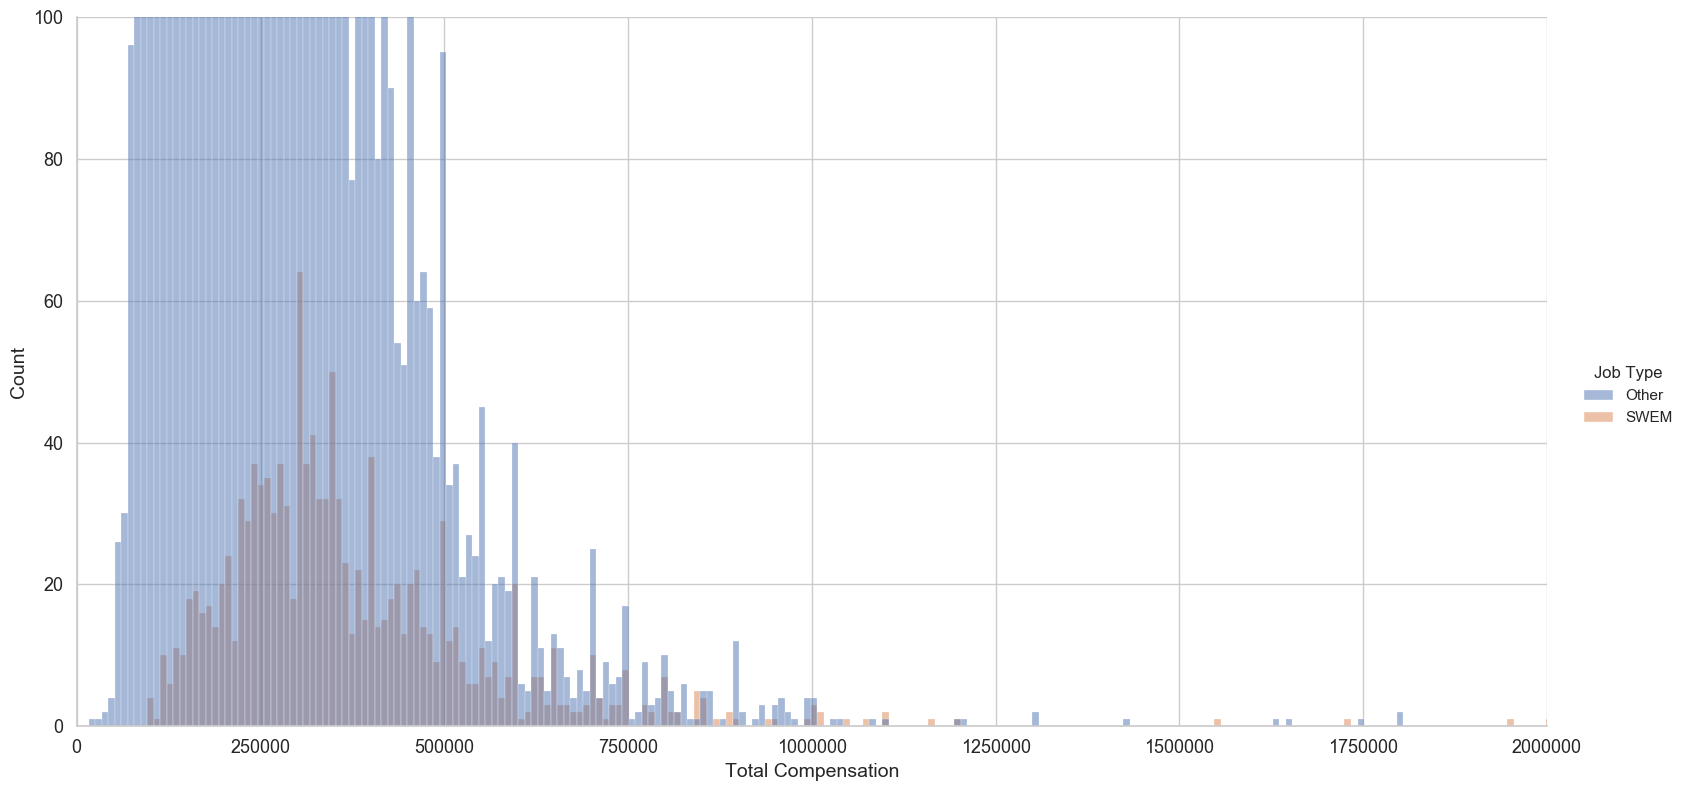

In [139]:
#For software engineering manager. Still looks reasonable to include in all data.
sns.set(rc = {'xtick.labelsize':13, 'ytick.labelsize':13, 'axes.labelsize': 14})
sns.set_style('whitegrid')
sns.displot(swem, x = 'Total Compensation', hue = 'Job Type', kind = 'hist',
            fill = True, height = 8, aspect = 2)
plt.xlim(0, 2000000)
#Comment ylim out to show full distribution, then include to focus in on SWEM dist.
plt.ylim(0, 100)
default_mpl()
sns.set_style('whitegrid')

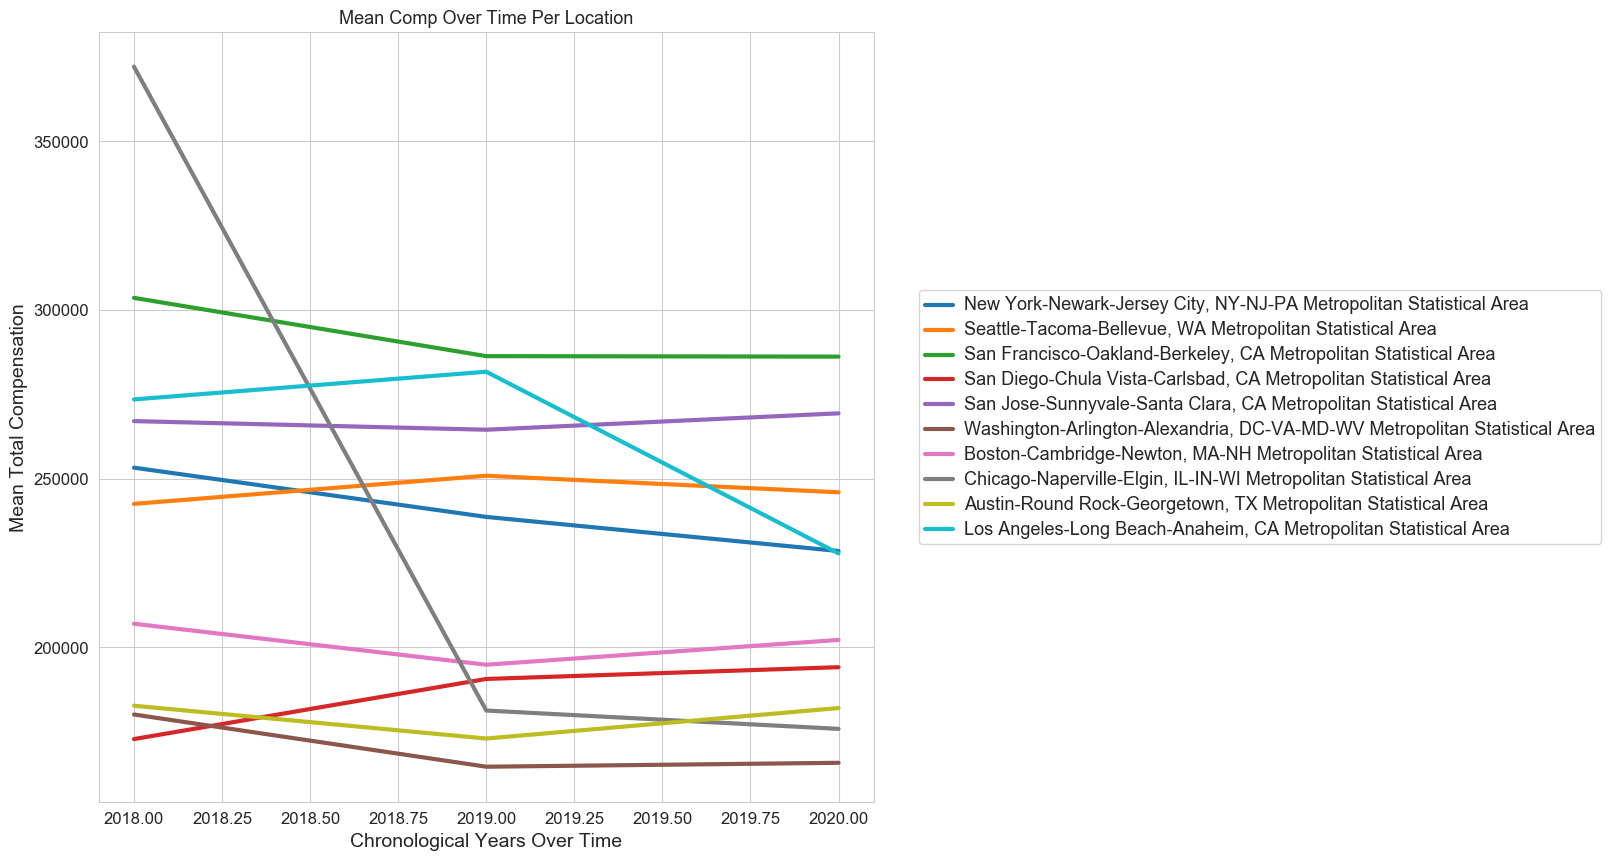

In [347]:
#Looking at lines by geography. Comment in / out lines below to look at location vs. Metropolitan.
#May need to change formatting aspects depending on which location (city states or metros) choose to plot.
#Similar to charts above, using chronology for x axis harder to read. Year gets the point across.

fix, ax = plt_sz(dim3)
g_l = sns.lineplot(
    #data = df_us[df_us.Location.isin(df_us.loc[:, 'Location'].value_counts().index[:10])],
    data = df_us[df_us.StdGeographyName.isin(df_us.loc[:, 'StdGeographyName'].value_counts().index[:10])],
    x = 'Year', y = 'Total Compensation',
    #hue = 'Location', ci = None, linewidth = 3)#, legend = None)
    hue = 'StdGeographyName', ci = None, linewidth = 3)
g_leg = g_l.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol = 1)
plt.setp(ax.get_legend().get_texts(), fontsize = '13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize = '13') # for legend title
#Increases legend linewidths.
for legobj in g_leg.legendHandles:
    legobj.set_linewidth(3.0)

cht_format(g_l, 'Mean Comp Over Time Per Location', 13,
           'Chronological Years Over Time', 14, 'Mean Total Compensation', 14, 12, rot_xlab = None)

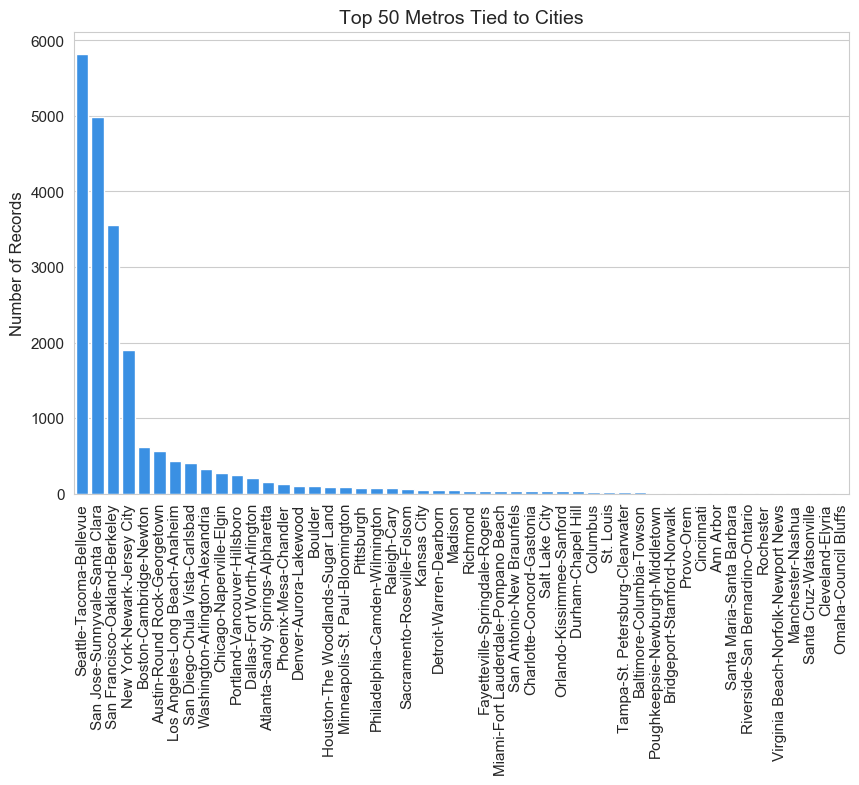

In [263]:
fig, ax = plt_sz(dim4)
met_cit = cnt_plt(df_us.StdGeographyName.str.split(',', expand = True), 0, params['clr'], order = 50)
# met_cit = cnt_plt(df_us, 'StdGeographyName', params['clr'], order = 50)
cht_format(met_cit, 'Top 50 Metros Tied to Cities', 14, '', 14, 'Number of Records', 12, 11, rot_xlab = 90)

In [274]:
#Identifying variables to be used in analysis.
cols1 = ['Years of Experience', 'Years at Company', 'Total Compensation', 'Base', 'Stock', 'Bonus',
         'CRMCYTOTC', 'DIVINDX_CY', 'X9001_I', 'HAI_CY']  + [c for c in df_us.columns if 'sqmi' in c]

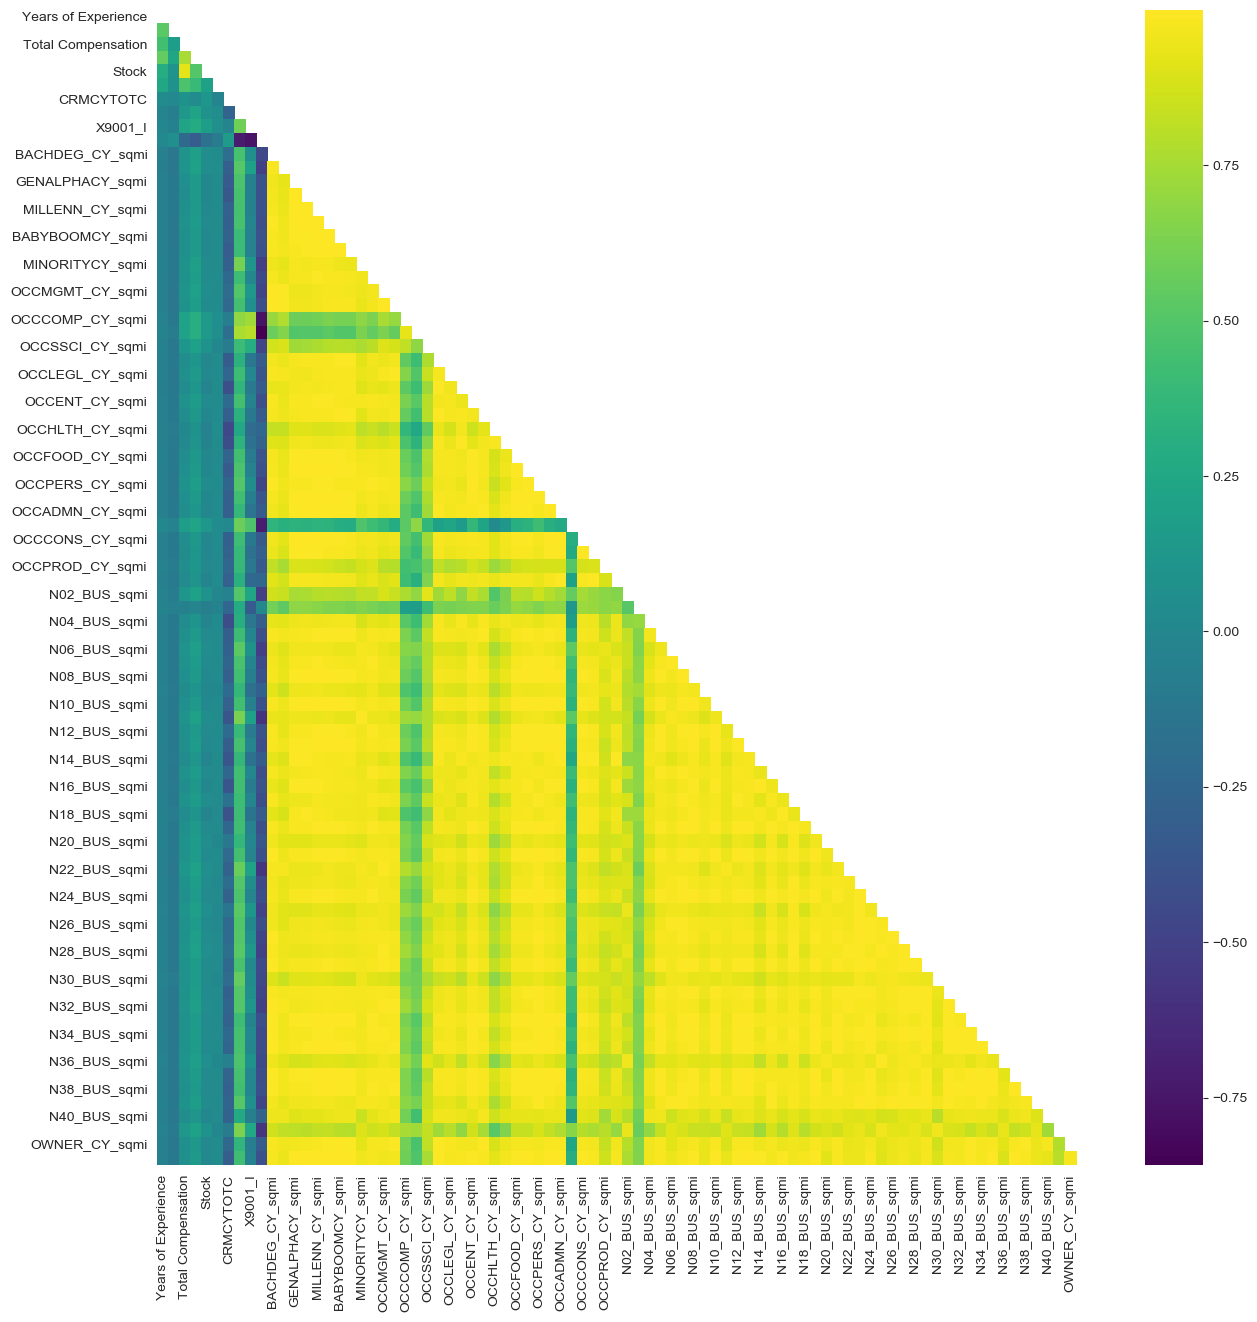

In [265]:
dim5 = (15, 15)
fix, ax = plt_sz(dim5)
cor_hmap(df_us[cols1], 'viridis')

In [240]:
#Trying without occupation variables to see if reduces multicollinearity.
#Identifying variables to be used in analysis.
cols2 = ['Years of Experience', 'Years at Company', 'Total Compensation', 'Base', 'Stock', 'Bonus',
         'CRMCYTOTC', 'DIVINDX_CY', 'X9001_I', 'HAI_CY']  \
        + [c for c in df_us.columns if 'sqmi' in c and 'OCC' not in c]

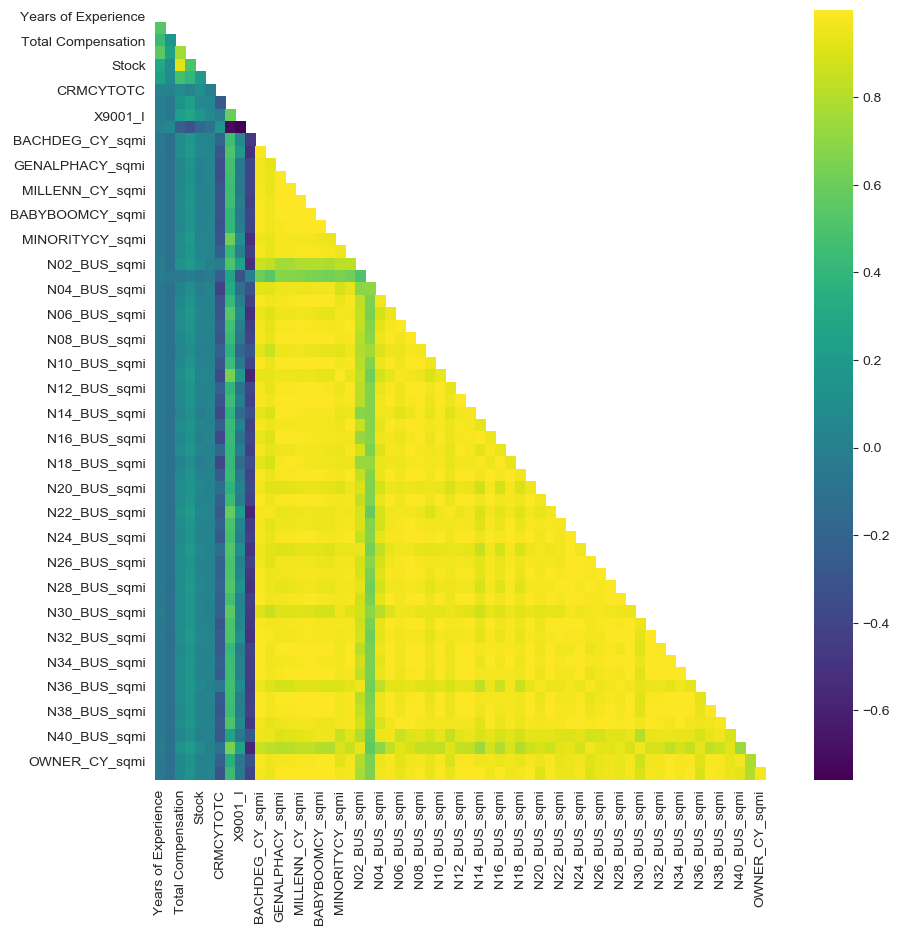

In [228]:
fix, ax = plt_sz(dim3)
cor_hmap(df_us[cols2], 'viridis')

In [243]:
#Trying without occupation variables to see if reduces multicollinearity.
#Identifying variables to be used in analysis.
cols3 = ['Years of Experience', 'Years at Company', 'Total Compensation', 'Base', 'Stock', 'Bonus',
         'CRMCYTOTC', 'DIVINDX_CY', 'X9001_I', 'HAI_CY']  \
        + [c for c in df_us.columns if 'sqmi' in c and 'OCC' not in c and '_BUS' not in c]

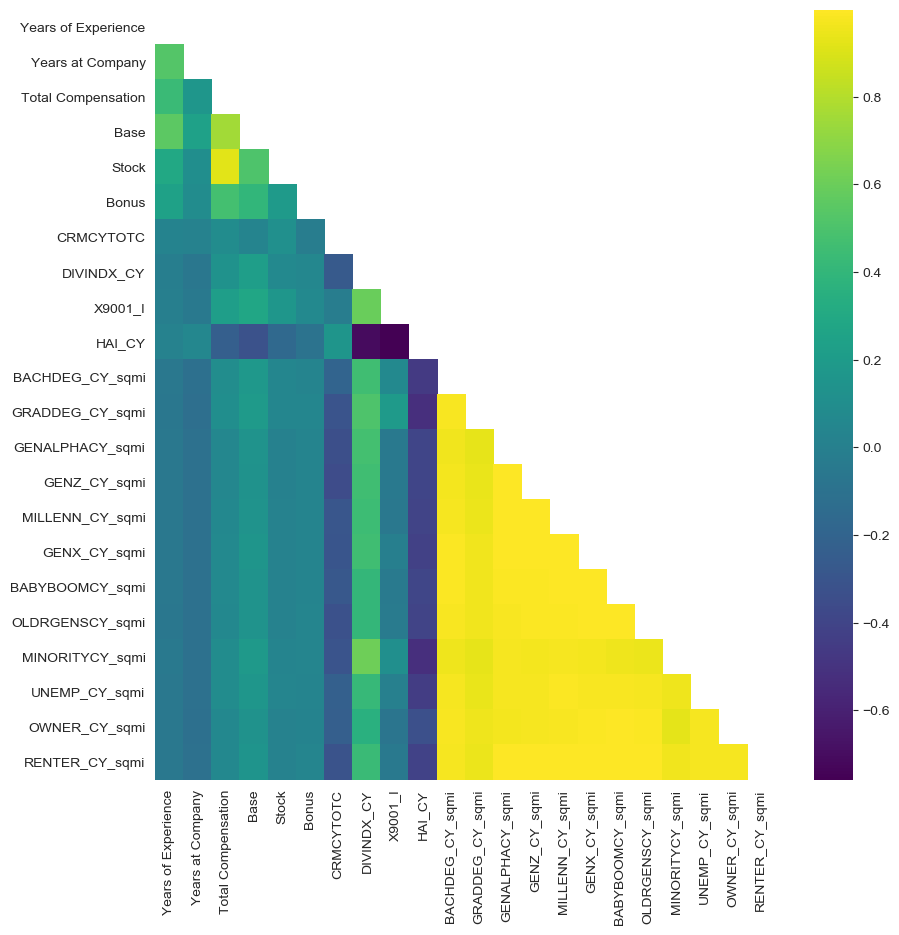

In [231]:
fix, ax = plt_sz(dim3)
cor_hmap(df_us[cols3], 'viridis')

In [244]:
cor_df = pd.DataFrame(df_us[cols3].corr().abs().unstack().sort_values(kind = 'quicksort')).reset_index()

In [275]:
#To look at correlations in wider tabular format...
cor_df.to_csv('corr_df.csv')

# Evaluating comparisons of metros, means, and medians.

In [5]:
#Keeping records in metro groups with at least 30 records in them.
df_us = df_us.groupby('StdGeographyName').filter(lambda x: len(x) >= 30)
#Creating shorter metro names.
df_us.loc[:, 'Metro'] = df_us.loc[:, 'StdGeographyName'].str.split('Metropolitan', expand = True)[0].str.strip()

In [7]:
tc = ['Metro', 'Total Compensation']
#Comparison dataframe of total comp mean, median, and n
compare = reduce(
    lambda f, s: pd.merge(f, s, on = tc[0]),
    [
        mean_median(df_us, tc).rename(columns = {tc[1]: f'Mean {tc[1]}'}),
        mean_median(df_us, tc, med = True).rename(columns = {tc[1]: f'Median {tc[1]}'}),
        df_us[tc].groupby(tc[0]).count().reset_index().rename(columns = {tc[1]: 'n'})
    ]
)

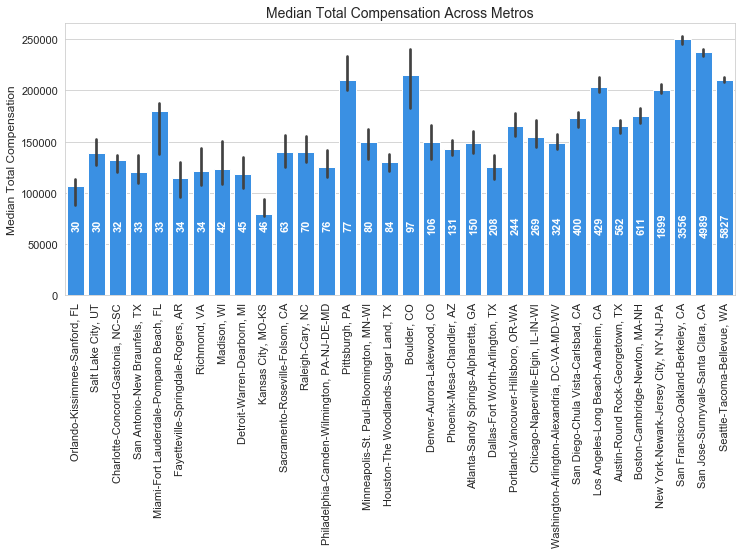

In [12]:
sns.set_style('whitegrid')
#Default estimator is mean.
fig, ax = plt.subplots(figsize = (12, 5))
# Note: order df supplied by aggregate compare df, not original df.
bp = sns.barplot(x = 'Metro', y = 'Total Compensation', data = df_us, estimator = np.median, color = 'dodgerblue',
                 order = compare.sort_values('n').Metro)
# bp = sns.barplot(x = 'Metro', y = 'Total Compensation', data = df_us, color = 'dodgerblue',
#                  order = compare.sort_values('n').Metro)
labs = bp.set_xticklabels(bp.get_xticklabels(), rotation = 90)
bar_lab = [l for l in compare.sort_values('n').n]
ind = 0
for p in bp.patches:
    bp.annotate(
        bar_lab[ind],
        (p.get_x() + p.get_width() / 1.75, 60000),#p.get_height() / 2.),
        ha = 'center', va = 'center',
        xytext = (0, 9),
        textcoords = 'offset points',
        rotation = 90,
        color = 'white',
        weight = 'bold',
        size = 11
    )
    ind += 1

cht_format(bp, 'Median Total Compensation Across Metros', 14,
           '', 12, 'Median Total Compensation', 12, 11, rot_xlab = 90)

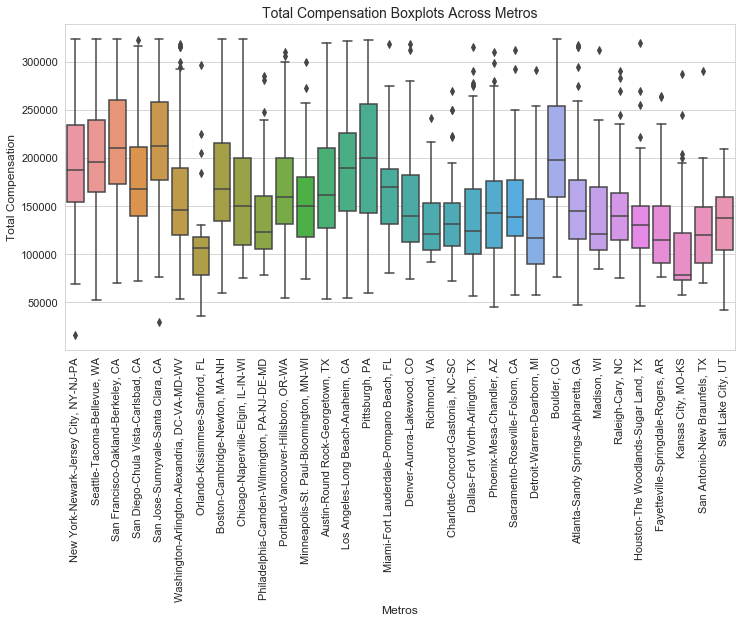

In [20]:
fig, ax = plt.subplots(figsize = (12, 6))
bp_metro = sns.boxplot(data = df_us[df_us.loc[:, 'Total Compensation'] < 325000], x = 'Metro', y = 'Total Compensation')
cht_format(bp_metro, 'Total Compensation Boxplots Across Metros', 14,
           'Metros', 12, 'Total Compensation', 12, 11, rot_xlab = 90)

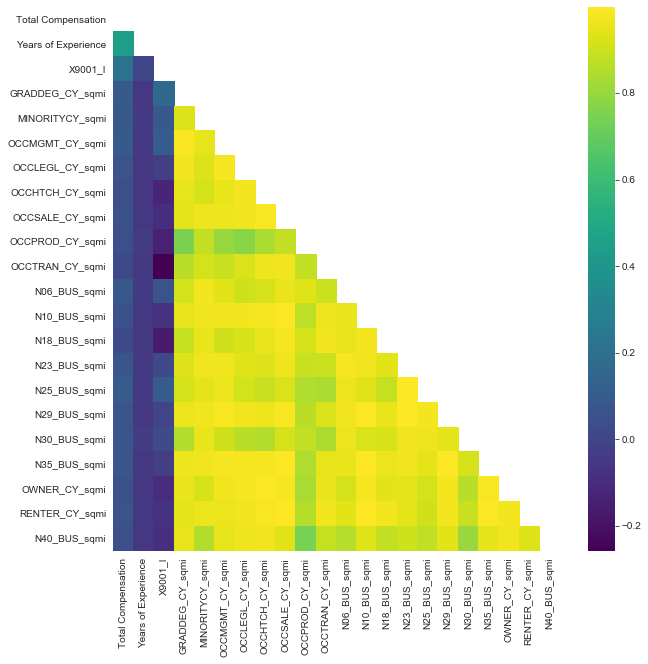

In [31]:
#The highly correlated variables AFTER the stepwise regression.
fix, ax = plt_sz((10, 10))
# cor_hmap(df_us[cols3], 'viridis')
ch = cor_hmap(
df_us[['Total Compensation', 'Years of Experience', 'X9001_I', 'Gender', 'Race', 'GRADDEG_CY_sqmi',
       'MINORITYCY_sqmi', 'OCCMGMT_CY_sqmi', 'OCCLEGL_CY_sqmi', 'OCCHTCH_CY_sqmi', 'OCCSALE_CY_sqmi',
       'OCCPROD_CY_sqmi', 'OCCTRAN_CY_sqmi', 'N06_BUS_sqmi', 'N10_BUS_sqmi', 'N18_BUS_sqmi',
       'N23_BUS_sqmi', 'N25_BUS_sqmi', 'N29_BUS_sqmi', 'N30_BUS_sqmi', 'N35_BUS_sqmi', 'OWNER_CY_sqmi',
       'RENTER_CY_sqmi', 'N40_BUS_sqmi']]
    , 'viridis'
)

# cht_format(ch, '', 0, '', 0, '', 0, 0, rot_xlab = None)

In [37]:
len(markers.MarkerStyle.markers)#.keys()

41

In [40]:
#Reading in comparison data.
comparison = pd.read_csv('comparisons.csv')

In [94]:
comparison.loc[:, 'MetroShort'] = comparison.Metro.str.split(',', expand = True)[0].str.split('-', expand = True)[0]

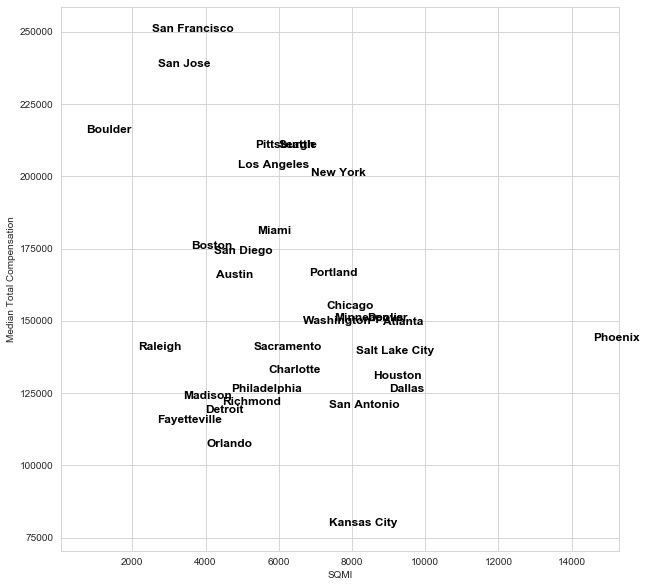

In [104]:
fix, ax = plt_sz((10, 10))
sc = sns.scatterplot(data = comparison, x = 'SQMI', y = 'Median Total Compensation',# style = 'Metro', legend = False,
                     legend = False,
                     hue = 'Metro', s = 0)#s = 200)
# sc_leg = sc.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol = 1)
# plt.setp(ax.get_legend().get_texts(), fontsize = '13') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize = '13') # for legend title

# cht_format(sc, 'Median Compensation per Metro Against...', 14,
#            'Square Miles', 12, 'Median Compensation', 12, 11, rot_xlab = 90)

for line in range(0, comparison.shape[0]):
     sc.text(comparison.loc[:, 'SQMI'][line], comparison.loc[:, 'Median Total Compensation'][line], comparison.MetroShort[line], horizontalalignment='left', size='large', color='black', weight='semibold')